# Project 2 - Advanced Methods in Applied Statistics 2024 - Emilie Jessen

In [47]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy 
from iminuit import Minuit
import lightgbm as lgb

In [48]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics

In [49]:
# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}
mpl.rc('font', **font)

axes = {'facecolor': 'ghostwhite'}
mpl.rc('axes', **axes)

# Add grid
mpl.rc('axes', grid=True)

# Set custom color cycle
custom_colors= ['dodgerblue', 'red', 'limegreen', 'orange', 'orchid', 'black', 'slategrey', 
                'navy', 'magenta', 'forestgreen', 'lightblue', 'maroon', 'gold', 'lightcoral', 
                'mediumseagreen', 'darkorange', 'darkviolet', 'dimgray', 'darkblue', 'darkred',]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)

# Set inside tickmarks
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True

In [50]:
save_plots = False

# Exercise 1a

In [51]:
data = pd.read_csv('earning_potential_train_test.txt', delimiter = ',', header=0, index_col=None)
data.sort_values(by='earning', inplace=True)

# Create target array  
# Dummification of Earning Column (1 - >50K, 0- <=50K)
data['earning'] = pd.get_dummies(data['earning'], drop_first=True, dtype=int)

In [52]:
data

,age,education,gender,hours-per-week,earning
0,39,13,0,40,0
2801,17,7,1,25,0
2802,35,10,0,60,0
2803,33,14,0,20,0
2804,25,12,1,40,0
...,...,...,...,...,...
773,37,11,1,24,1
2546,24,10,0,70,1
1493,53,9,0,35,1
1492,45,9,0,40,1


In [53]:
# Find the number of individuals with high/low earnings in the full data set
N_high = np.sum(data['earning'] == True)
N_low = np.sum(data['earning'] == False)
ratio = N_high / N_low

# Print results
print(f'There are {len(data)} individuals included in the full data set.')
print(f'Higher income earners: {N_high}')
print(f'Lower income earners: {N_low}')
print(f'The ratio of higher to lower income earners is {ratio:.2f}.')

There are 4500 individuals included in the full data set.
Higher income earners: 1091
Lower income earners: 3409
The ratio of higher to lower income earners is 0.32.


In [54]:
# Split the data into a training and test set
train = pd.concat([data.iloc[:int(N_low/2)], data.iloc[N_low:int(N_low + N_high/2 + 1)]])

# Find the number of individuals with high/low earnings in the full data set
N_high_train = np.sum(train['earning'] == True)
N_low_train = np.sum(train['earning'] == False)
ratio_train = N_high_train / N_low_train

# Print results
print(f'There are {len(train)} individuals included in the training data set.')
print(f'Higher income earners: {N_high_train}')
print(f'Lower income earners: {N_low_train}')
print(f'The ratio of higher to lower income earners is {ratio_train:.2f}.')


There are 2250 individuals included in the training data set.
Higher income earners: 546
Lower income earners: 1704
The ratio of higher to lower income earners is 0.32.


In [55]:
# Split the data into a training and test set
test = pd.concat([data.iloc[int(N_low/2): int(N_low)], data.iloc[int(N_low + N_high/2 + 1):]])

# Find the number of individuals with high/low earnings in the full data set
N_high_test = np.sum(test['earning'] == True)
N_low_test = np.sum(test['earning'] == False)
ratio_test = N_high_test / N_low_test

# Print results
print(f'There are {len(test)} individuals included in the test data set.')
print(f'Higher income earners: {N_high_test}')
print(f'Lower income earners: {N_low_test}')
print(f'The ratio of higher to lower income earners is {ratio_test:.2f}.')

There are 2250 individuals included in the test data set.
Higher income earners: 545
Lower income earners: 1705
The ratio of higher to lower income earners is 0.32.


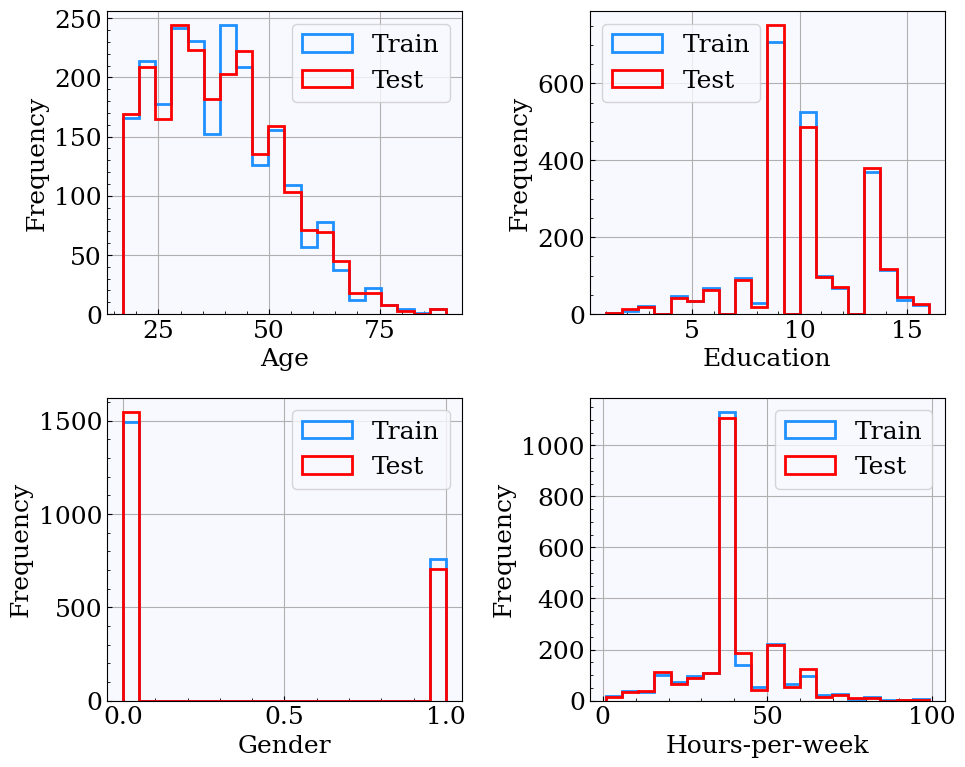

In [56]:
# Plot the distribution of the four variables for the training and test set 

fig, ax = plt.subplots(2, 2, figsize=(10, 8))

# Age
ax[0, 0].hist(train['age'], bins=20, histtype='step', label='Train', lw=2)
ax[0, 0].hist(test['age'], bins=20, histtype='step', label='Test', lw=2)

ax[0, 0].set_xlabel('Age')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].legend()

# Education
ax[0, 1].hist(train['education'], bins=20, histtype='step', label='Train', lw=2)
ax[0, 1].hist(test['education'], bins=20, histtype='step', label='Test', lw=2)

ax[0, 1].set_xlabel('Education')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].legend()

# Gender
ax[1, 0].hist(train['gender'], bins=20, histtype='step', label='Train', lw=2)
ax[1, 0].hist(test['gender'], bins=20, histtype='step', label='Test', lw=2)

ax[1, 0].set_xlabel('Gender')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].legend()

# Hours-per-week
ax[1, 1].hist(train['hours-per-week'], bins=20, histtype='step', label='Train', lw=2)
ax[1, 1].hist(test['hours-per-week'], bins=20, histtype='step', label='Test', lw=2)

ax[1, 1].set_xlabel('Hours-per-week')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].legend()

fig.tight_layout()

if save_plots:
    plt.savefig('earning_potential_train_test.png', dpi=300)

In [57]:
# Separating the independent and target variable on both data sets
x_train = train.drop(columns = ['earning'], axis = 1).values
y_train = train['earning'].values
x_test = test.drop(columns = ['earning'], axis = 1).values
y_test = test['earning'].values

# Shuffling the data
np.random.seed(42)
idx = np.arange(len(x_train))
np.random.shuffle(idx)
x_train = x_train[idx]
y_train = y_train[idx]

idx = np.arange(len(x_test))
np.random.shuffle(idx)
x_test = x_test[idx]
y_test = y_test[idx]

In [58]:
from sklearn.ensemble import GradientBoostingClassifier

# Specify parameters and distributions to sample from (center around the best values from previous search)

model = GradientBoostingClassifier()

parameters_RandomSearch = {'max_depth': scipy.stats.randint(1, 5), 
                           'n_estimators': scipy.stats.randint(1, 150),
                           'learning_rate': scipy.stats.uniform(0.01, 0.5),}

# Chose number of iterations and number of folds
n_iter_search = 20

RandomSearch = RandomizedSearchCV(model, 
                                  param_distributions=parameters_RandomSearch,
                                  n_iter=n_iter_search,
                                  return_train_score=True,
                                  scoring = 'balanced_accuracy')

# Fit the random search instance
RandomSearch.fit(x_train, y_train);

# Get results
RandomSearch_results = pd.DataFrame(RandomSearch.cv_results_)                 
print("Random Search: \tBest parameters: ", RandomSearch.best_params_, f", Best scores: {RandomSearch.best_score_:.3f}")

RandomSearch_results.head(3)

Random Search: 	Best parameters:  {'learning_rate': 0.4063790567864064, 'max_depth': 1, 'n_estimators': 131} , Best scores: 0.659


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.064221,0.038609,0.002411,0.000820,0.068602,1,39,"{'learning_rate': 0.0686019528401167, 'max_dep...",0.547526,0.546060,...,0.543253,0.012649,20,0.533635,0.534002,0.559715,0.540177,0.554454,0.544396,0.010747
1,0.018951,0.002691,0.001084,0.000116,0.081421,2,17,"{'learning_rate': 0.08142098240716593, 'max_de...",0.542939,0.563319,...,0.545504,0.015717,19,0.534002,0.575454,0.552029,0.568632,0.552527,0.556529,0.014480
2,0.018644,0.000266,0.000987,0.000048,0.113126,1,26,"{'learning_rate': 0.1131260569180763, 'max_dep...",0.547526,0.574148,...,0.556910,0.022460,18,0.533635,0.597324,0.559715,0.584004,0.554454,0.565826,0.022474


In [59]:
# Create the Gradient Boosted classifier
bdt = GradientBoostingClassifier(max_depth=1, 
                                 n_estimators=77, 
                                 learning_rate=0.43)

# Train the classifier  
model = bdt.fit(x_train, y_train)

# Test the classifier
y_pred_binary = model.predict(x_test)
y_pred = model.predict_proba(x_test)

# Model Accuracy, how often is the classifier correct?
accuracy_score = metrics.accuracy_score(y_test, y_pred_binary)
print(f'Accuracy: {accuracy_score:.2f}')

Accuracy: 0.81


In [60]:
y_pred[:15]

array([[0.99711806, 0.00288194],
       [0.96449031, 0.03550969],
       [0.97428118, 0.02571882],
       [0.65298377, 0.34701623],
       [0.88415229, 0.11584771],
       [0.41444561, 0.58555439],
       [0.63748881, 0.36251119],
       [0.69000043, 0.30999957],
       [0.65061896, 0.34938104],
       [0.8383865 , 0.1616135 ],
       [0.64883823, 0.35116177],
       [0.86582583, 0.13417417],
       [0.54773024, 0.45226976],
       [0.92625287, 0.07374713],
       [0.97622025, 0.02377975]])

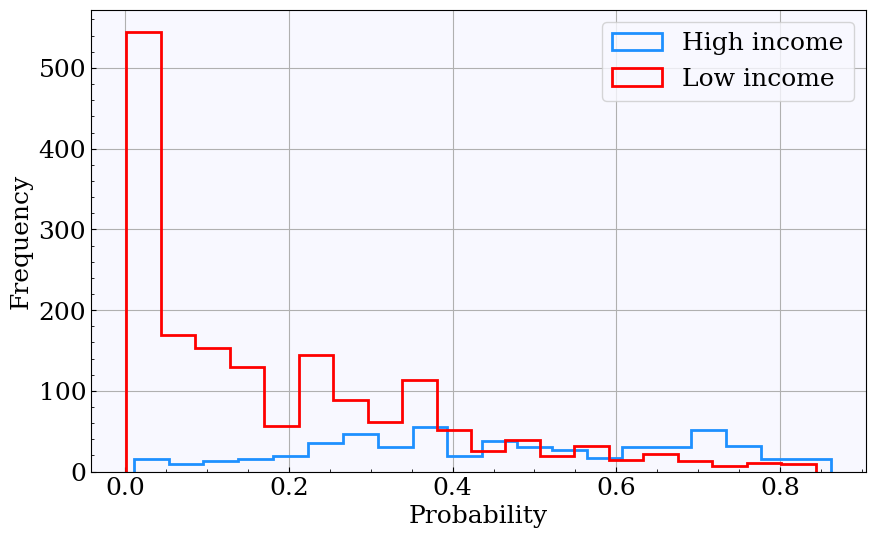

In [61]:
# Plot probability distribution

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# High income
y_pred_high = y_pred[y_test == 1][:, 1]
y_pred_low = y_pred[y_test == 0][:, 1]

ax.hist(y_pred_high, bins=20, histtype='step', label='High income', lw=2)
ax.hist(y_pred_low, bins=20, histtype='step', label='Low income', lw=2)

ax.set_xlabel('Probability')
ax.set_ylabel('Frequency')
ax.legend()


# Exercise 1b

# Exercise 2

In [62]:
# Loading the data 
data = pd.read_csv('cpd-crash-incidents.csv', delimiter=';', header=0, usecols=["lon", "lat", 'crash_date'])

# Negative longitude implies ‘West’, whereas positive implies ‘East’ from a spot in
# Greenwich Park in London, England

# Exercise 2a

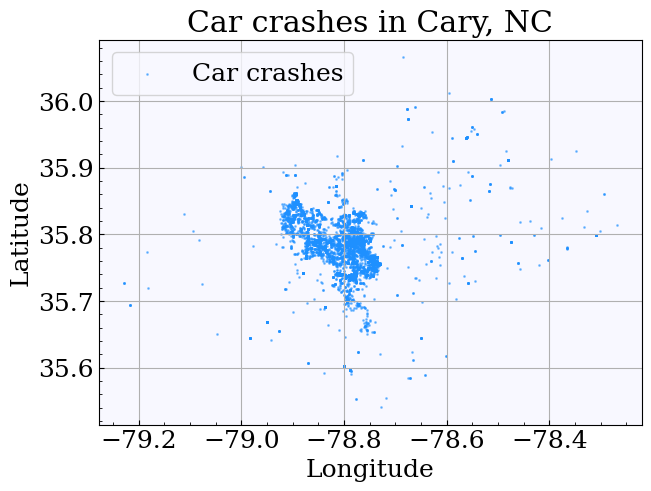

In [63]:
# Scatter plot of the car crashes, as a function of longitude and latitude

fig, ax = plt.subplots(figsize=(7, 5))

ax.scatter(data['lon'], data['lat'], s=1, alpha=0.5, label='Car crashes')
ax.set(xlabel='Longitude', 
       ylabel='Latitude', 
       title='Car crashes in Cary, NC')

ax.legend()

if save_plots:
       plt.savefig('car_crashes_cary.png', dpi=300)

In [64]:
# Histogram of the car crashes, as a function of the time of day (in hours)

# Extracting the hour and minutes of the day from the crash_date
data['crash_date'] = pd.to_datetime(data['crash_date'])
data['time_hour'] = data['crash_date'].dt.hour + data['crash_date'].dt.minute/60

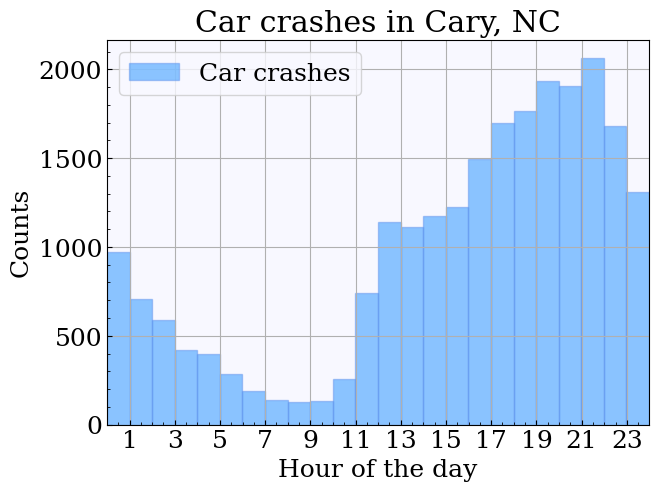

In [65]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.hist(data['time_hour'], bins=24, alpha=0.5, edgecolor='cornflowerblue', label='Car crashes')
ax.set(xlabel='Hour of the day', 
       ylabel='Counts', 
       title='Car crashes in Cary, NC', 
       xticks=np.arange(1, 25, 2),
       xlim=(0, 24))


ax.legend()

if save_plots:
         plt.savefig('car_crashes_cary_hour.png', dpi=300)

In [66]:
# Describe how would you create a kernel density estimation using a gaussian
# kernel with a bandwidth of 0.25 hours to produce a probability density function
# of the time of day for crashes

#N.B. For a 24-hour clock, time ‘wraps’ at 00:00 & 24:00. For example, 00:01 and 23:59 are
#very close to each other in actual time, but not numerically.

# Kernel density estimation (KDE) is a non-parametric way to estimate the probability density function of a random variable.
# The kernel function is a non-negative function that integrates to one and has a mean of zero.
# The bandwidth parameter controls the smoothness of the estimated density. A large bandwidth will produce a smoother density,
# but it will also smooth out the true underlying density. A small bandwidth will produce a density estimate that is closer to the true density, but it will also be more noisy.

# The Gaussian kernel is a popular choice for KDE, and it is defined as:
# K(x) = (1/sqrt(2*pi)) * exp(-x^2/2)

# The kernel density estimate is then given by:
# f(x) = (1/nh) * sum(K((x-xi)/h))

# where n is the number of data points, h is the bandwidth, and K is the kernel function.



# Exercise 2b 

In [67]:
# Create a kernel density estimation using an Epanechnikov kernel with a bandwidth of
# 0.8 hours to produce a probability density function of the time of day for crashes

def epanechnikov_kernel(u, h):
    """Function to calculate the Epanechnikov kernel"""

    if np.abs(u) <= 1:
        return 3 / 4 * (1 - u**2)
    else:
        return 0
    
def KDE(data, point, h, kernel):
    """Function to calculate the kernel density estimate"""

    N = len(data)
    u = (point - data)

    # Ensure the wrapping of the data is considered, i.e. we want 12 hours on each side
    u[u > 12] -= 24 
    u[u < -12] += 24
    u /= h

    KDE = 1 / (N * h) * np.sum(np.array([kernel(i, h) for i in u]))

    return KDE

In [68]:
N_points = 24 * 60
t_axis = np.linspace(0, 24, N_points)
h = 0.8

# Create the kernel density estimate

KDE_epanechnikov = np.array([KDE(data['time_hour'], t, h, epanechnikov_kernel) for t in t_axis])

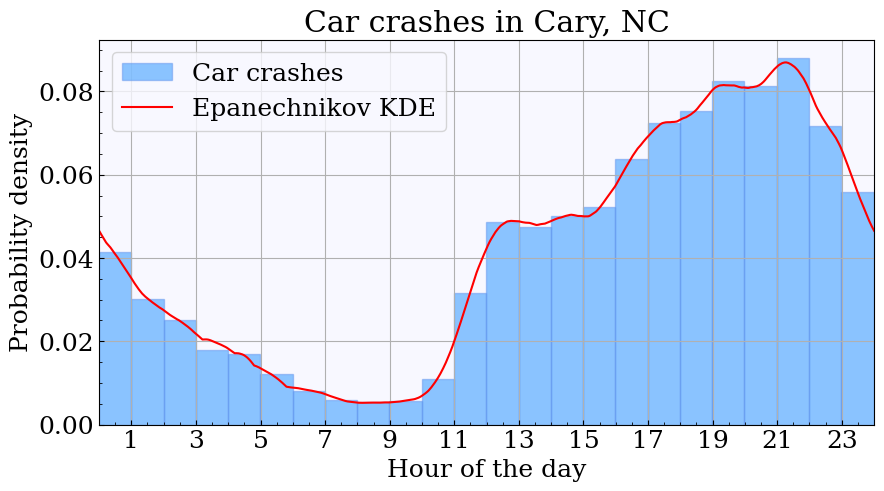

In [69]:
# Plot the KDE

fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(data['time_hour'], bins=24, alpha=0.5, edgecolor='cornflowerblue', label='Car crashes', density=True)
ax.plot(t_axis, KDE_epanechnikov, label='Epanechnikov KDE')
ax.set(xlabel='Hour of the day', 
       ylabel='Probability density', 
       title='Car crashes in Cary, NC', 
       xticks=np.arange(1, 25, 2),
       xlim=(0, 24))

ax.legend()

if save_plots:
    plt.savefig('car_crashes_cary_KDE.png', dpi=300)

KDE for 0:23: 0.0422
KDE for 1:49: 0.0284
KDE for 8:12: 0.0052
KDE for 15:55: 0.0565
KDE for 18:02: 0.0733
KDE for 21:12: 0.0869
KDE for 23:44: 0.0510


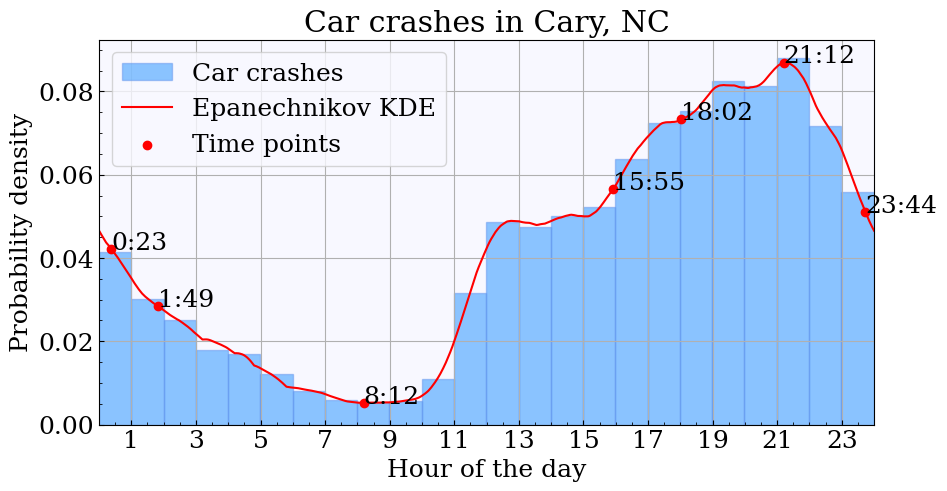

In [70]:
# Defining the time points from the assignment
hours = np.array([0, 1, 8, 15, 18, 21, 23])
minutes = np.array([23, 49, 12, 55, 2, 12, 44])

time_points = hours + minutes/60

# KDE for the time points
KDE_epanechnikov_points = np.array([KDE(data['time_hour'], t, h, epanechnikov_kernel) for t in time_points])

# Print the KDE for the time points
for i in range(len(hours)):
    if minutes[i] < 10:
        print(f'KDE for {hours[i]}:0{minutes[i]}: {KDE_epanechnikov_points[i]:.4f}')
    else:
        print(f'KDE for {hours[i]}:{minutes[i]}: {KDE_epanechnikov_points[i]:.4f}')


# Plot the KDE and the time points
        
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(data['time_hour'], bins=24, alpha=0.5, edgecolor='cornflowerblue', label='Car crashes', density=True)
ax.plot(t_axis, KDE_epanechnikov, label='Epanechnikov KDE')
ax.scatter(time_points, KDE_epanechnikov_points, color='red', label='Time points')
ax.set(xlabel='Hour of the day', 
       ylabel='Probability density', 
       title='Car crashes in Cary, NC',
       xticks=np.arange(1, 25, 2),
       xlim=(0, 24))

# Plot the time points
for i in range(len(hours)):
    if minutes[i] < 10:
        ax.text(time_points[i], KDE_epanechnikov_points[i], f'{hours[i]}:0{minutes[i]}')
    else:
        ax.text(time_points[i], KDE_epanechnikov_points[i], f'{hours[i]}:{minutes[i]}')

ax.legend()

if save_plots:
    plt.savefig('car_crashes_cary_KDE_points.png', dpi=300)

In [71]:
# KDE PDF describes the relative crash likelihood during a 24-hour window
# If additional police patrolled the entire 24-hour time, then there would be a 10% decrease in the likelihood of accidents
# So what is the percentage of the 24-hour daily crashes that will be reduced by your 2-hour window?

window = 2 * 60         # 2-hour window
t_cyclic = np.concatenate((t_axis, t_axis[:window]))  # Add the overlapping part

KDE_epanechnikov_cyclic = np.concatenate((KDE_epanechnikov, KDE_epanechnikov[:window]))
KDE_decreased = KDE_epanechnikov_cyclic * 0.9     # 10% decrease in the likelihood of accidents

dt = np.diff(t_axis)[0]
total_KDE_integral = np.trapz(KDE_epanechnikov, dx=dt)  # Total integral of the KDE

reduction = np.zeros(N_points)

for i in range(N_points):
    end = i + window
    KDE_integral = np.trapz(KDE_epanechnikov_cyclic[i:end], dx=dt)
    KDE_decreased_integral = np.trapz(KDE_decreased[i:end], dx=dt)
    reduction[i] = (KDE_integral - KDE_decreased_integral) / total_KDE_integral * 100

In [72]:
# Find the maximum reduction

max_reduction = np.max(reduction)
max_reduction_time_start = t_axis[np.argmax(reduction)]
max_reduction_time_end = t_axis[np.argmax(reduction) + window]

print(f'The maximum reduction of {max_reduction:.2f}% occurs between') 
print(f'{int(max_reduction_time_start):.0f}:{(max_reduction_time_start*60) % 60:.0f} and {int(max_reduction_time_end):.0f}:{(max_reduction_time_end*60) % 60:.0f} hours')

The maximum reduction of 1.66% occurs between
19:58 and 21:58 hours


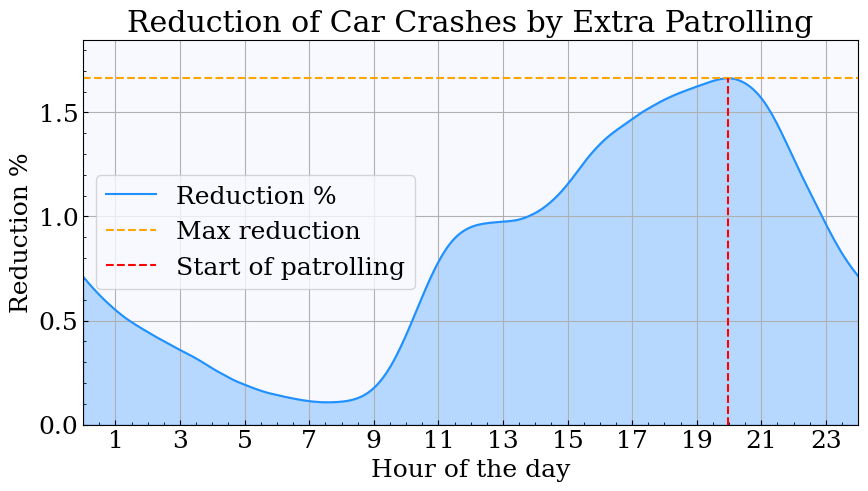

In [73]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(t_axis, reduction, label='Reduction %')
ax.fill_between(t_axis, reduction, 0, color='dodgerblue', alpha=0.3)
ax.hlines(max_reduction, 0, 24, color='orange', linestyle='--', label='Max reduction')
ax.vlines(max_reduction_time_start, 0, max_reduction, color='red', linestyle='--', label='Start of patrolling')
ax.set(xlabel='Hour of the day', 
       ylabel='Reduction %', 
       title='Reduction of Car Crashes by Extra Patrolling', 
       xticks=np.arange(1, 25, 2),
       xlim=(0, 24), 
       ylim=(0, 1.85))

ax.legend(loc='center left')

if save_plots:
    plt.savefig('car_crashes_cary_KDE_decreased.png', dpi=300)


# Exercise 2c 

In [74]:
from sklearn.neighbors import KernelDensity

# Remove NaN values
lat = data['lat'][~np.isnan(data['lat'])]
lon = data['lon'][~np.isnan(data['lat'])]
lat = data['lat'][~np.isnan(data['lon'])]
lon = data['lon'][~np.isnan(data['lon'])]
pos = np.stack([lon, lat], axis=1)

h_2D = 0.01

longitude = np.linspace(np.min(lon), np.max(lon), 1000)
latitude = np.linspace(np.min(lat), np.max(lat), 1000)

xx, yy = np.meshgrid(longitude, latitude)  # Create a grid of latitude and longitude
xy_plot = np.stack([xx.ravel(), yy.ravel()], axis=1)

kde_2D = KernelDensity(kernel='epanechnikov', bandwidth=h_2D).fit(pos) # creating density from samples
pdf_2D = np.exp(kde_2D.score_samples(xy_plot))
pdf_2D = pdf_2D.reshape(1000, 1000)

In [75]:
# Define the box
box_lon = np.array([-78.76, -78.72])
box_lat = np.array([35.74, 35.78])

dx = longitude[1] - longitude[0]
dy = latitude[1] - latitude[0]

# Percentage of crashes inside the box
mask_lon = [(longitude > box_lon[0]) & (longitude < box_lon[1])]
mask_lat = [(latitude > box_lat[0]) & (latitude < box_lat[1])]
LON_mask, LAT_mask = np.meshgrid(mask_lon, mask_lat)
box_mask = LON_mask & LAT_mask
box_integral = np.sum(pdf_2D[box_mask] * dx * dy )

print(f'The percentage of crashes inside the box is {box_integral * 100:.2f}%')

The percentage of crashes inside the box is 13.87%


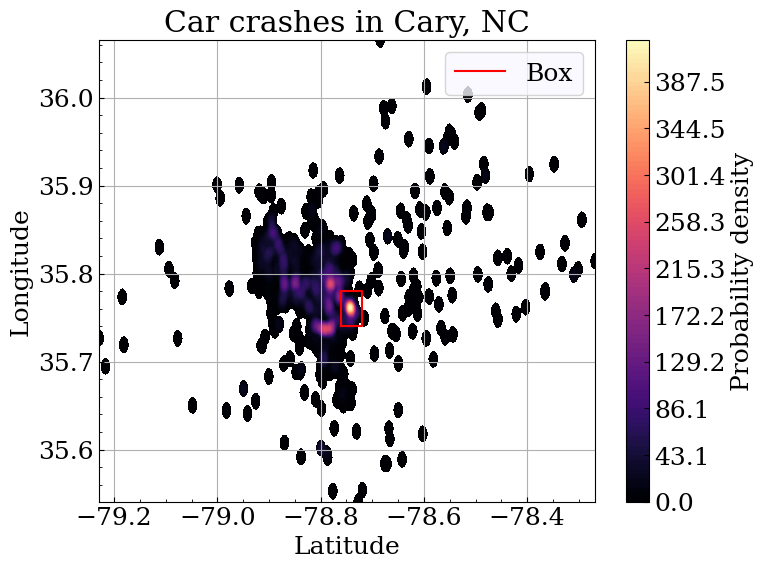

In [76]:
fig, ax = plt.subplots(figsize=(8,6))

# Plotting
contour_levels = np.linspace(pdf_2D.min(), pdf_2D.max(), 100)
sc = ax.contourf(longitude, latitude, pdf_2D, levels=contour_levels, cmap='magma')
fig.colorbar(sc, ax=ax, label='Probability density')

ax.contourf(longitude, latitude, pdf_2D, levels=[0, 0.0001], colors=['white'])


# Plot the box
ax.plot([box_lon[0], box_lon[1], box_lon[1], box_lon[0], box_lon[0]], 
        [box_lat[0], box_lat[0], box_lat[1], box_lat[1], box_lat[0]], 
        color='red', linestyle='-', label='Box')

ax.set(xlabel='Latitude',
         ylabel='Longitude',
         title='Car crashes in Cary, NC')

ax.legend()

if save_plots:
    plt.savefig('car_crashes_cary_2D_KDE.png', dpi=300)

# Exercise 3a

In [89]:
# Loading the data 
nuc_data = np.loadtxt('NucData.txt', skiprows=0)

# Defining the number of trials and events
N_trials = 100
N_events = 200

def integrator(t, b, sigma):
    """Function to calculate the integrant for the probability density function"""
    t_mark = np.linspace(0, 300, 900)
    exp = np.exp(-t_mark / b) / b 
    gauss = np.exp(-(t - t_mark)**2 / (2 * sigma**2)) / (np.sqrt(2 * np.pi) * sigma)
    integrant = exp * gauss
    return np.trapz(integrant, t_mark)
    

def pdf(t, b, sigma):
    """Function to calculate the probability density function 
    for a exponential decay with Gaussian resolution"""
    t_array = np.sort(t.ravel())
    t_array = np.sort(t)
    func = np.array([integrator(t_array[i], b, sigma) for i in range(len(t_array))])
    func /= np.trapz(func, t_array)
    return func


def llh(data, b, sigma): 
    """Function to calculate the log-likelihood function"""
    return np.sum(np.log(pdf(np.sort(data), b, sigma)))

In [90]:
# Fit the 100 psedo-experiments with 200 events in each 

# Arrays for storing values for null hypothesis
b_values0 = np.zeros(N_trials)
sigma_values0 = np.zeros(N_trials)
llh_vals0 = np.zeros(N_trials)

# Arrays for storing values for alternative hypothesis
b_values1 = np.zeros(N_trials)
sigma_values1 = np.zeros(N_trials)
llh_vals1 = np.zeros(N_trials)

# Array for storing the likelihood ratio
llh_ratio = np.zeros(N_trials)

# Initial values for the fit
initial_values = [1, 0.5]

for i in range(N_trials):

    # Extract data
    data = nuc_data[i*N_events:(i+1)*N_events]
    data = np.sort(np.sort(data.ravel()))

    def fit_obj(b, sigma): 
        return -llh(data, b, sigma)

    # Testing null hypothesis b = 1
    minuit = Minuit(fit_obj, *initial_values)
    minuit.fixed['b'] = True
    minuit.limits['sigma'] = (0.1, None)
    minuit.migrad()

    b_values0[i] = minuit.values[0]
    sigma_values0[i] = minuit.values[1]
    llh_vals0[i] = llh(data, 1, sigma_values0[i])

    # Testing alternative hypothesis b != 1
    minuit = Minuit(fit_obj, *initial_values)
    minuit.limits['b'] = (0.1, None)
    minuit.limits['sigma'] = (0.1, None)
    minuit.migrad()
    
    b_values1[i] = minuit.values[0]
    sigma_values1[i] = minuit.values[1]
    llh_vals1[i] = llh(data, b_values1[i], sigma_values1[i])

    # Calculate the likelihood "ratio"
    llh_ratio[i] = -2 * (llh_vals0[i] - llh_vals1[i])

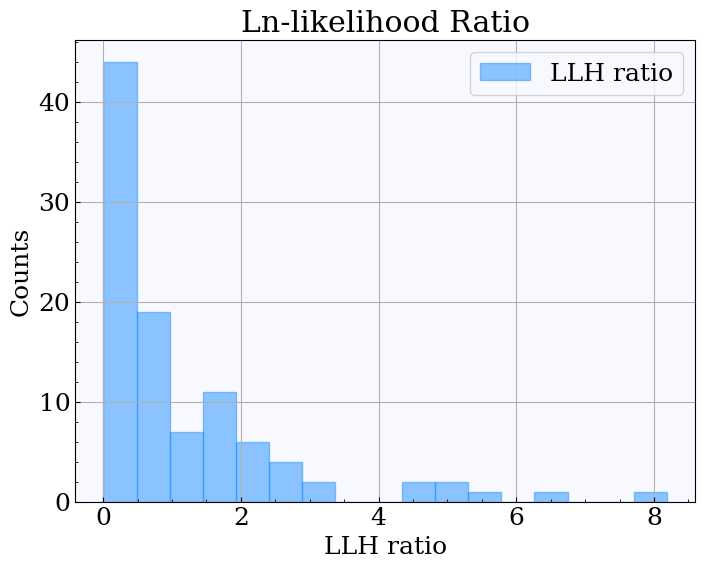

In [107]:
# Plot the likelihood values

fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(llh_ratio, bins=17, edgecolor='dodgerblue', alpha=0.5, label='LLH ratio')
ax.set(xlabel='LLH ratio', 
       ylabel='Counts', 
       title='Ln-likelihood Ratio')

ax.legend()

if save_plots:
       plt.savefig('likelihood_ratio.png', dpi=300)

# Exercise 3b 

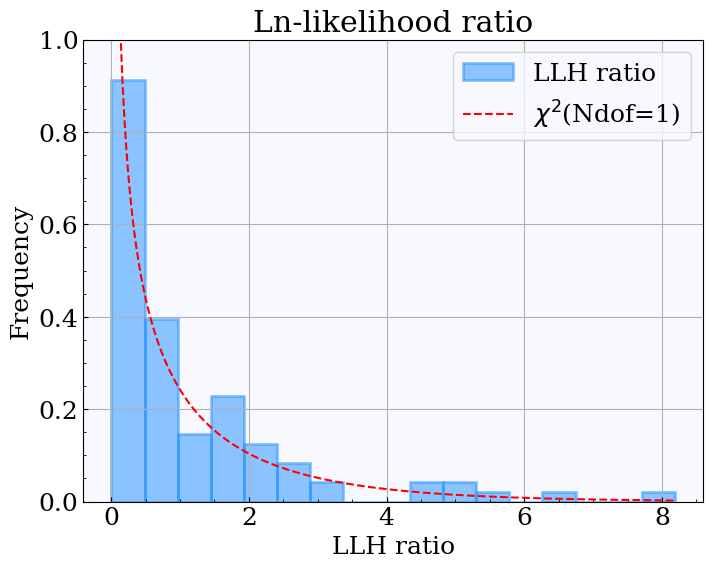

In [108]:
# Plot the likelihood values and the chi2 distribution with 1 degree of freedom
# 1 degree of freedom since the difference in dimensionalyty between the two models is 1

llh_axis = np.linspace(llh_ratio.min(), llh_ratio.max(), 1000)

fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(llh_ratio, bins=17, lw=2, alpha=0.5, edgecolor='dodgerblue', density=True, label='LLH ratio')
ax.plot(llh_axis, scipy.stats.chi2.pdf(llh_axis, 1), '--', label=r'$\chi^2$(Ndof=1)')
ax.set(xlabel='LLH ratio', 
       ylabel='Frequency', 
       title='Ln-likelihood ratio',
       ylim=(0, 1))

ax.legend()

if save_plots:
       plt.savefig('likelihood_ratio_chi2.png', dpi=300)

In [109]:
# Kolmogorov-Smirnov test for the likelihood ratio distribution and the chi2 distribution

ks_stat, p_value = scipy.stats.kstest(np.sort(llh_ratio), scipy.stats.chi2.cdf, args=(1,))

print(f'The Kolmogorov-Smirnov test gives a p-value of {p_value:.3f}')

ratio_cut = np.sum(llh_ratio > 2.706)

print(f'The number of the likelihood ratio values that are larger than 2.706 is {ratio_cut:.0f}')

sf = scipy.stats.chi2.sf(2.706, 1)

print(f'For a chi2-distribution with 1 degree of freedom for 100 data points:')
print(f'we would expect {sf*100:.0f} ratio values to be larger than 2.706')

The Kolmogorov-Smirnov test gives a p-value of 0.051
The number of the likelihood ratio values that are larger than 2.706 is 10
For a chi2-distribution with 1 degree of freedom for 100 data points:
we would expect 10 ratio values to be larger than 2.706


In [97]:
def cdf(sample, x, sort = False):
    # Sorts the sample, if unsorted
    if sort:
        sample.sort()

    # Counts how many observations are below x
    cdf = sum(sample <= x)

    # Divides by the total number of observations
    cdf = cdf / len(sample)
    
    return cdf

cdf_vals = np.array([cdf(llh_ratio, i, sort=True) for i in llh_axis])

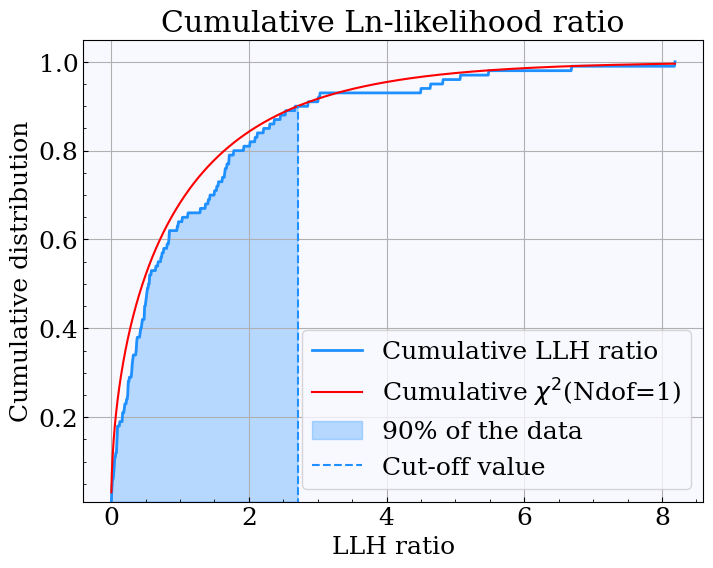

In [105]:
# Plot cumulative distribution function of the likelihood ratio
percent = (100-ratio_cut)/100,
idx = int(np.argwhere(cdf_vals > percent)[0])

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(llh_axis, cdf_vals, lw=2, label='Cumulative LLH ratio')
ax.plot(llh_axis, scipy.stats.chi2.cdf(llh_axis, 1), label=r'Cumulative $\chi^2$(Ndof=1)')
ax.fill_betweenx(cdf_vals[:idx], llh_axis[:idx], 2.706, color='dodgerblue', alpha=0.3, label=f'{100-ratio_cut}% of the data')
ax.vlines(2.706, 0, percent, color='dodgerblue', linestyle='--', label='Cut-off value')


ax.set(xlabel='LLH ratio',
         ylabel='Cumulative distribution',
         title='Cumulative Ln-likelihood ratio',
         ylim=(0.01, 1.05))

ax.legend()

if save_plots:
    plt.savefig('likelihood_ratio_cdf.png', dpi=300)
